In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train']


In [2]:
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch

In [3]:
data_folder = Path("../input")

In [4]:
train_df = pd.read_csv("../input/train/train.csv")
test_df = pd.read_csv("../input/test/test.csv")

In [5]:
train_df.head()

,id,label
0,1,9
1,2,0
2,3,0
3,4,3
4,5,0


In [14]:
test_img = ImageList.from_df(test_df, path=data_folder/'test', folder='test',suffix='.png')
trfm = get_transforms(do_flip=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)
train_img = (ImageList.from_df(train_df, path=data_folder/'train', folder='train',suffix='.png')
        .split_by_rand_pct(0.1)
        .label_from_df()
        .add_test(test_img)
        .transform(trfm, size=299)
        .databunch(path='.', bs=64, device= torch.device('cuda:0'))
        .normalize(imagenet_stats)
       )

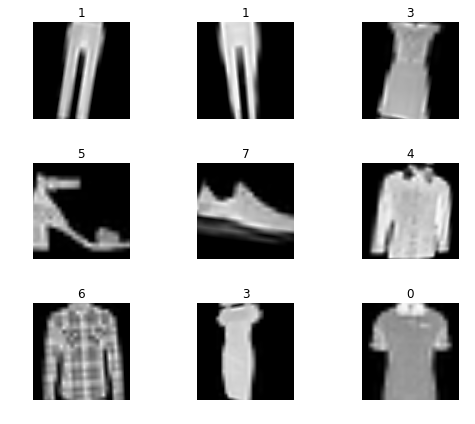

In [15]:
train_img.show_batch(rows=3, figsize=(7,6))

In [16]:
learn = cnn_learner(train_img, models.resnet50, metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


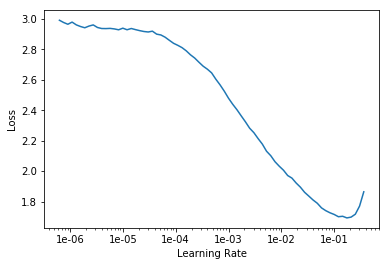

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
lr = 2e-03
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.503876,0.368778,0.865833,11:01
1,0.336448,0.263056,0.900000,10:46
2,0.298521,0.220249,0.916167,10:52
3,0.253680,0.203242,0.925500,10:41
4,0.236427,0.195742,0.926500,10:35


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


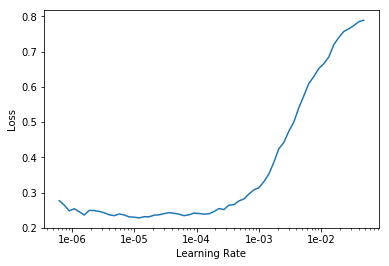

In [19]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(2, slice(5e-06))

epoch,train_loss,valid_loss,accuracy,time
0,0.244517,0.196498,0.925833,11:26
1,0.234833,0.193971,0.927167,11:22


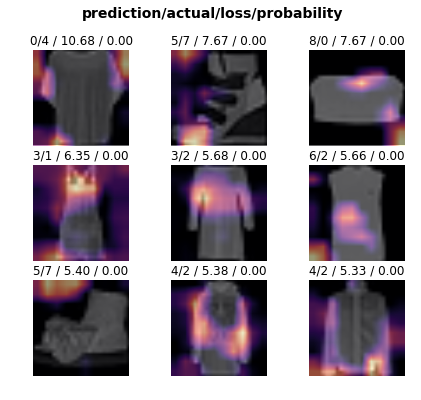

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(7,6))

In [22]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)
labelled_preds = [np.argmax(preds[i]) for i in range(len(preds))]
labelled_preds = np.array(labelled_preds)

In [23]:
df = pd.DataFrame({'id':test_df['id'], 'label':labelled_preds}, columns=['id', 'label'])
df.to_csv('submission.csv', index=False)

In [24]:
from IPython.display import HTML
def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

In [25]:
create_download_link(filename = 'submission.csv')